# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum, isnan, to_date, to_timestamp, from_unixtime, count
from pyspark.sql.window import Window
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pyspark.sql.functions as F
from pyspark.sql.functions import col, count_distinct, countDistinct

from pyspark.sql.types import LongType, TimestampType
from pyspark.sql.functions import substring, from_unixtime

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df_original = df

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Easier visual exploration as Pandas data frame
df.limit(5).toPandas()

# Questions to explore:
# sessionId unique across users? (can two users have the same sessionId?)
# what is the column "method"

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
# Do some users switch between subscription levels? > yes
df.groupby("userId").agg(F.count_distinct("level")).show(5)

+------+---------------------+
|userId|count(DISTINCT level)|
+------+---------------------+
|100010|                    1|
|200002|                    2|
|   125|                    1|
|     7|                    1|
|   124|                    1|
+------+---------------------+
only showing top 5 rows



#### Extract State from Location

Only US states contained in the subset.

In [7]:
# Which locations are contained in the data set?
print(f"{df.select('location').distinct().count()} unique locations.")

df.select("location").distinct().show(5)

115 unique locations.
+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Kingsport-Bristol...|
|New Haven-Milford...|
|         Dubuque, IA|
+--------------------+
only showing top 5 rows



In [8]:
# Extract state with regex

# https://stackoverflow.com/questions/4419000/regex-match-everything-after-question-mark
df = df.withColumn("state", F.regexp_extract(df.location, "\, (.*)", 1))
df.show(5)

# Are there users who used the service from multiple states? --> no
df.groupBy("userId").agg(F.count_distinct("state").alias("distinct_state")).sort("distinct_state", ascending=False).show()

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|   CA|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

#### Extract Device

In [9]:
print(f'Distinct user agents: {df.select("userAgent").distinct().count()}') # there are 57 distinct user agents (OS & browser combinations)

df.select("userAgent").distinct().show(5)

Distinct user agents: 57
+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
+--------------------+
only showing top 5 rows



In [10]:
# Keywords to group by (manual analysis of the distinct user agents): Windows, Macintosh, iPhone, Linux, iPad

# Create dummy variables for these groups with text search

# https://stackoverflow.com/questions/40161879/pyspark-withcolumn-with-two-conditions-and-three-outcomes
device_detailed =   F.when(F.locate("Windows", df.userAgent) > 0, "Windows")\
                        .otherwise(F.when(F.locate("Macintosh", df.userAgent) > 0, "MacIntosh")\
                        .otherwise(F.when(F.locate("iPhone", df.userAgent) > 0, "iPhone")\
                        .otherwise(F.when(F.locate("Linux", df.userAgent) > 0, "Linux")\
                        .otherwise(F.when(F.locate("iPad", df.userAgent) > 0, "iPad")
                        .otherwise("other")
                    ))))


device_group =   F.when(F.locate("Windows", df.userAgent) > 0, "Windows")\
                    .otherwise(F.when(
                                        (F.locate("Macintosh", df.userAgent) > 0) | 
                                        (F.locate("iPhone", df.userAgent) > 0) | 
                                        (F.locate("iPad", df.userAgent) > 0), "Apple")\
                    .otherwise(F.when(F.locate("Linux", df.userAgent) > 0, "Linux")\
                    .otherwise("other")))
                

df = df.withColumn("deviceGroup", device_group)
df = df.withColumn("deviceGroupDetailed", device_detailed)


# To be tested whether the more detailed grouping makes sense since iPad & iPhone represent a small percentage
df.groupBy("deviceGroupDetailed").count().show()

df.groupBy("deviceGroup").count().show()

+-------------------+------+
|deviceGroupDetailed| count|
+-------------------+------+
|               iPad| 11381|
|             iPhone| 11192|
|              Linux|  8961|
|              other|  8346|
|          MacIntosh|102749|
|            Windows|143871|
+-------------------+------+

+-----------+------+
|deviceGroup| count|
+-----------+------+
|      Linux|  8961|
|      other|  8346|
|      Apple|125322|
|    Windows|143871|
+-----------+------+



In [11]:
# Do users use multiple devices to access the service? --> no

df.groupBy("userId").agg(F.count_distinct("deviceGroup").alias("unique_devices")).sort("unique_devices", ascending=False).show(5)

+------+--------------+
|userId|unique_devices|
+------+--------------+
|100010|             1|
|200002|             1|
|   125|             1|
|    51|             1|
|     7|             1|
+------+--------------+
only showing top 5 rows



In [12]:
# Distinct values per column
# https://stackoverflow.com/questions/40888946/spark-dataframe-count-distinct-values-of-every-column

distinct_value_count = df.agg(*(F.countDistinct(F.col(c)).alias(c) for c in df.columns)).show()
distinct_value_count

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+-----+-----------+-------------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status|    ts|userAgent|userId|state|deviceGroup|deviceGroupDetailed|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+-----+-----------+-------------------+
| 17655|   4|      189|     2|         1322|     173| 14865|    2|     114|     2|  22|         225|     2354|58480|     3|277447|       56|   226|   58|          4|                  6|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+-----+-----------+-------------------+



## Cleanup & Prep of Timestamp and Date

In [13]:
# Check for null values in the timestamp column
# https://stackoverflow.com/questions/48229043/python-pyspark-count-null-empty-and-nan
df.filter((df["ts"] == "") | df["ts"].isNull() | isnan(df["ts"])).count()

0

In [14]:
# Remove milliseconds (last 3 digits) from ts to enable conversion to datetime
df = df.withColumn("ts_no_ms", substring(df.ts, 0, 10))
# df = df.withColumn("ts_no_ms", df.ts_no_ms.cast(TimestampType()))
# df = df.withColumn("ts_unix", from_unixtime(df.ts))
df = df.withColumn("ts_str", F.from_unixtime(df.ts_no_ms))
df = df.withColumn("ts_date", F.to_date(F.from_unixtime(df.ts_no_ms)))


df = df.withColumn("ts_tsType", df.ts_str.cast(TimestampType()))

df = df.withColumn("weekday", F.weekday(df.ts_tsType))
df = df.withColumn("day_of_week", F.dayofweek(df.ts_tsType))
df = df.withColumn("day", F.date_format(df.ts_tsType, "E"))
df = df.withColumn("hour", F.hour(df.ts_tsType))
df = df.withColumn("year", F.year(df.ts_tsType))
df = df.withColumn("weekNum", F.weekofyear(df.ts_tsType))

# df.printSchema()
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+

In [15]:
# Format registration date and days since registration per user
df = df.withColumn("registration_date", F.to_date(F.from_unixtime(substring(df.registration, 0, 10))))

# How to efficiently find the last date / ts when each user used the service?
window = Window.partitionBy(["userId"])
df = df.withColumn("last_visited_date", F.max(col("ts_date")).over(window))

df = df.withColumn("days_since_registration", F.date_diff(col("last_visited_date"), col("registration_date")))

df.show(5)


### Code to verify correct calculation of days_since_registration:
# df.where(df.userId == 132).show()
# df.groupBy("userId").agg(F.max("registration_date"), F.max("ts_date")).show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+-

In [16]:
df.agg(F.min("ts_date"), F.max("ts_date") ).show()

+------------+------------+
|min(ts_date)|max(ts_date)|
+------------+------------+
|  2018-10-01|  2018-12-03|
+------------+------------+



## Analysis and handling of null values

In [17]:
# https://stackoverflow.com/questions/64147246/pyspark-need-to-show-a-count-of-null-empty-values-per-each-column-in-a-datafram
df.select(*(count(F.when(col(c).isNull(), c)).alias(c) for c in df.columns)).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+-----------+-------------------+--------+------+-------+---------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|state|deviceGroup|deviceGroupDetailed|ts_no_ms|ts_str|ts_date|ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+-----------+-------------------+--------+------+-------+---------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+
| 58392|   0|     8346|  8346|            0

In [18]:
# df.filter(df.gender.isNull()).show()

df.filter(df.auth == "Cancelled").show(5)

df.filter(df.auth == "Guest").show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+--------+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|   state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+-

In [19]:
df.groupBy("gender").count().show()

df.groupBy("auth").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  NULL|  8346|
|     M|123576|
+------+------+

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Logged In|278102|
| Cancelled|    52|
|     Guest|    97|
+----------+------+



In [20]:
# See which pages can be visited as a logged in user / guest
df.groupBy(["auth", "page"]).count().sort("auth").show(100)

+----------+--------------------+------+
|      auth|                page| count|
+----------+--------------------+------+
| Cancelled|Cancellation Conf...|    52|
|     Guest|            Register|    18|
|     Guest|               About|    14|
|     Guest|               Error|     1|
|     Guest| Submit Registration|     5|
|     Guest|                Help|    23|
|     Guest|                Home|    36|
| Logged In|              Logout|  3226|
| Logged In|           Thumbs Up| 12551|
| Logged In|         Roll Advert|  3933|
| Logged In|      Submit Upgrade|   159|
| Logged In|            Settings|  1514|
| Logged In|         Thumbs Down|  2546|
| Logged In|       Save Settings|   310|
| Logged In|                Help|  1454|
| Logged In|            NextSong|228108|
| Logged In|               About|   495|
| Logged In|     Add to Playlist|  6526|
| Logged In|               Error|   252|
| Logged In|                Home| 10082|
| Logged In|          Add Friend|  4277|
| Logged In|    

In [21]:
# Keep only logged in users & cancellations in the data set
df = df.filter((df.auth == "Logged In") | (df.auth == "Cancelled"))

# https://stackoverflow.com/questions/64147246/pyspark-need-to-show-a-count-of-null-empty-values-per-each-column-in-a-datafram
df.select(*(count(F.when(col(c).isNull(), c)).alias(c) for c in df.columns)).show()

# --> The only remaining null values are for the columns artist, length and song from page visits other than "Next song"

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+-----------+-------------------+--------+------+-------+---------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|state|deviceGroup|deviceGroupDetailed|ts_no_ms|ts_str|ts_date|ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+-----------+-------------------+--------+------+-------+---------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+
| 50046|   0|        0|     0|            0

In [22]:
# Remove cancellation confirmation from df that will be pivoted for feature engineering
df_pages_share = df.filter((df.auth == "Logged In") & (df.page != "Cancel"))

df_pages_share = df_pages_share.groupBy(["userId", "page"]).count().sort(["userId", "page"])
df_pages_share = df_pages_share.withColumnRenamed("count", "page_visits")
# df_pages_share = df_pages_share.where("")


window = Window.partitionBy(["userId"])

df_pages_share = df_pages_share.withColumn("sum_page_visits", F.sum(col("page_visits")).over(window))
df_pages_share = df_pages_share.withColumn("share_page_visits", (df_pages_share.page_visits / F.sum(col("page_visits")).over(window)))


df_pages_share.show()

+------+---------------+-----------+---------------+--------------------+
|userId|           page|page_visits|sum_page_visits|   share_page_visits|
+------+---------------+-----------+---------------+--------------------+
|    10|          About|          2|            795|0.002515723270440...|
|    10|     Add Friend|         12|            795| 0.01509433962264151|
|    10|Add to Playlist|          9|            795|0.011320754716981131|
|    10|      Downgrade|          7|            795| 0.00880503144654088|
|    10|           Help|          1|            795|0.001257861635220...|
|    10|           Home|         30|            795| 0.03773584905660377|
|    10|         Logout|         11|            795|0.013836477987421384|
|    10|       NextSong|        673|            795|  0.8465408805031447|
|    10|    Roll Advert|          1|            795|0.001257861635220...|
|    10|  Save Settings|          1|            795|0.001257861635220...|
|    10|       Settings|          7|  

In [23]:
join_df_pages_share = df_pages_share.groupBy("userId").pivot("page").max("share_page_visits").fillna(0)
join_df_pages_share.show()

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|userId|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|       Save Settings|            Settings|    Submit Downgrade|      Submit Upgrade|         Thumbs Down|           Thumbs Up|             Upgrade|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [24]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- state: string (nullable = true)
 |-- deviceGroup: string (nullable = false)
 |-- deviceGroupDetailed: string (nullable = false)
 |-- ts_no_ms: string (nullable = true)
 |-- ts_str: string (nullable = true)
 |-- ts_date: date (nullable = true)
 |-- ts_tsType: timestamp (nullable = true)
 |-- weekday: 

In [25]:
# Number of unique users in this subset of data
df.agg(countDistinct("userID")).collect()[0][0]

225

In [26]:
# Are all of these unique cancellations or did some users resubscribe and cancel again?
df.where(df.page=="Cancellation Confirmation").groupBy("userId").count().sort("count", ascending=False).head(10)
# > No, all cancellations are from unique users

[Row(userId='18', count=1),
 Row(userId='32', count=1),
 Row(userId='125', count=1),
 Row(userId='51', count=1),
 Row(userId='101', count=1),
 Row(userId='17', count=1),
 Row(userId='143', count=1),
 Row(userId='105', count=1),
 Row(userId='121', count=1),
 Row(userId='129', count=1)]

#### Interaction-Based Churn Flag

In [27]:
df = df.withColumn("churnFlag", F.when(df.page=="Cancellation Confirmation", 1).otherwise(0))
df.where(df.churnFlag==1).show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+--------+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+---------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|   state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|churnFlag|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--

#### User-Based Churn Flag

In [28]:
df.createOrReplaceTempView("user_logs")

# Issue, the distinct userId also selects rows where the flag is not present

df_sql = spark.sql('''
    SELECT *, IF(flag = 1, 1, 0) AS userChurned
    FROM user_logs
    LEFT JOIN (
        SELECT DISTINCT userId AS uid, 1 AS flag
        FROM user_logs
        WHERE churnFlag = 1
        ) AS churned_users
    ON user_logs.userId = churned_users.uid
    '''
)

df_sql = df_sql.drop(*["uid", "flag"])

df_sql.show()

df = df_sql

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+---------+-----------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|churnFlag|userChurned|
+--------------------+---------+---------+------+-------------+---------+---------+-----+---------------

In [29]:
df_sql.filter((df_sql.userChurned == 1) & (df_sql.page != "Cancellation Confirmation")).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+---------+-----------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|churnFlag|userChurned|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------

#### sessionId Analysis
Could the sessionId be a useful feature? --> No

In [30]:
# Count per distinct sessionId
df.groupBy("sessionId").count().sort("sessionId").show()

# Count per distinct sessionId & userId
df.groupBy("sessionId", "userId").count().sort("sessionId").show()

# --> Seems to have no meaningful logic since not all users have data for session 1 - x

+---------+-----+
|sessionId|count|
+---------+-----+
|        1|  680|
|        2|    7|
|        3|   37|
|        4|   24|
|        5|   57|
|        6|   68|
|        7|    1|
|        8|   45|
|        9|  190|
|       10|  165|
|       11|   46|
|       12|   59|
|       13|  119|
|       15|  213|
|       16|   39|
|       17|  169|
|       18|   27|
|       19|  151|
|       20|   29|
|       21|  127|
+---------+-----+
only showing top 20 rows

+---------+------+-----+
|sessionId|userId|count|
+---------+------+-----+
|        1|     2|  428|
|        1|100001|   51|
|        1|300001|  201|
|        2|200002|    7|
|        3|100003|    2|
|        3|300003|   35|
|        4|100004|   24|
|        5|     6|    5|
|        5|100005|   52|
|        6|100006|   44|
|        6|300006|   24|
|        7|200007|    1|
|        8|     9|   45|
|        9|    10|   70|
|        9|100009|   28|
|        9|300009|   92|
|       10|200010|   86|
|       10|    11|    9|
|       10|300010

## Visualizations on Sparkify usage

Songs played per hour of the day

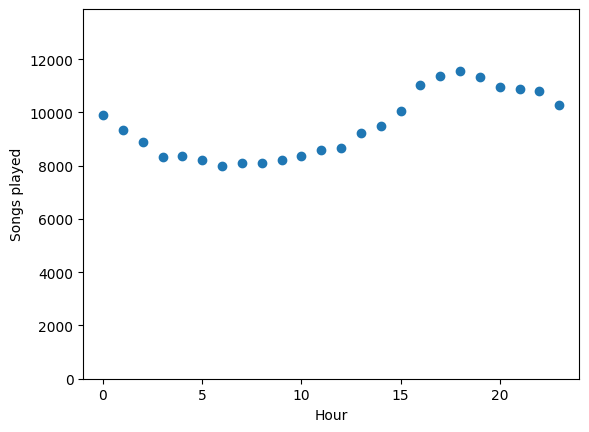

In [31]:
songs_in_hour = df.filter(df.page == "NextSong").groupby("hour").count().sort("hour").toPandas()

plt.scatter(songs_in_hour["hour"], songs_in_hour["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [32]:
def groupby_plot(df, x_col:str, page_filter:str, x_label:str, y_label:str):
    """Aggregate data and create scatterplot to visualize trends in the data."""
    # df_grouped = df.groupby(x_col).count().sort(x_col).toPandas()
    df_grouped = df.filter(df.page == page_filter).groupby(x_col).count().sort(x_col).toPandas()
    plt.scatter(df_grouped[x_col], df_grouped["count"])
    plt.xlim(-1, max(df_grouped[x_col])+1);
    plt.ylim(0, 1.2 * max(df_grouped["count"]))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show
    return None

In [33]:
# https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
df.agg(*(F.countDistinct(col(c)).alias(c) for c in df.columns)).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,day_of_week,day,hour,year,weekNum,registration_date,last_visited_date,days_since_registration,churnFlag,userChurned
0,17655,2,189,2,1311,173,14865,2,114,2,...,7,7,24,1,10,87,49,110,2,2


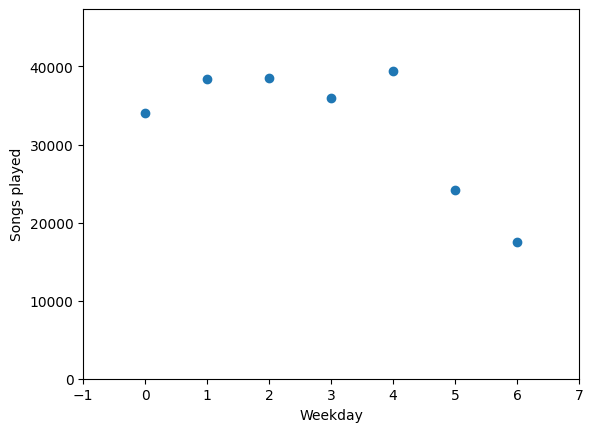

In [34]:
groupby_plot(df, "weekday", "NextSong", "Weekday", "Songs played")

### Compare characteristics of both groups (churned & active users)

In [35]:
df.groupBy(["userChurned"]).count().sort("userChurned").show()

+-----------+------+
|userChurned| count|
+-----------+------+
|          0|233290|
|          1| 44864|
+-----------+------+



##### Usage statistics by churned / active

In [36]:
df_grouped_churn = df.groupBy(["userChurned"]).agg(
                                                F.count_distinct("userId").alias("user_count"),
                                                # F.max("userChurned").alias("userChurned"),
                                                F.mean("length").alias("avg_length"), 
                                                F.sum("length").alias("sum_length"),
                                                F.count("length").alias("played_songs"),
                                                (F.count("length").alias("played_songs") / F.count_distinct("userId")).alias("avg_songs_played")
                                                ).toPandas()

df_grouped_churn

,userChurned,user_count,avg_length,sum_length,played_songs,avg_songs_played
0,1,52,248.632796,9.048742e+06,36394,699.884615
1,0,173,249.209135,4.777688e+07,191714,1108.173410


In [37]:
df_churn_gender = df.groupBy(["gender", "userChurned"]).agg(
                                                F.count_distinct("userId").alias("user_count"),
                                                F.mean("length").alias("avg_length"), 
                                                (F.count("length").alias("played_songs") / F.count_distinct("userId")).alias("avg_songs_played")
                                                ).sort("gender", "userChurned").toPandas()

df_churn_gender

,gender,userChurned,user_count,avg_length,avg_songs_played
0,F,0,84,249.040817,1324.476190
1,F,1,20,247.588930,772.000000
2,M,0,89,249.441883,904.022472
3,M,1,32,249.401970,654.812500


The churn rate is slightly higher for male users.

https://seaborn.pydata.org/examples/grouped_barplot.html

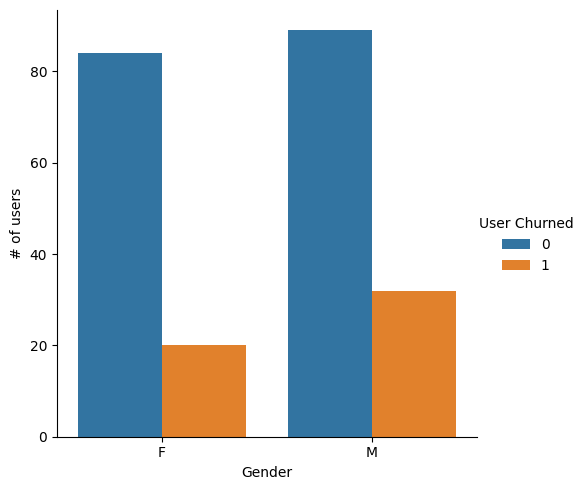

In [38]:
sns.catplot(
    data=df_churn_gender, kind="bar",
    x="gender", y="user_count", hue="userChurned"
)\
.set_axis_labels("Gender", "# of users")\
.legend.set_title("User Churned")

plt.savefig("plots/barplot_churn_by_gender.png")

The groups are almost indistinguishable when looking at the average time each song was played.

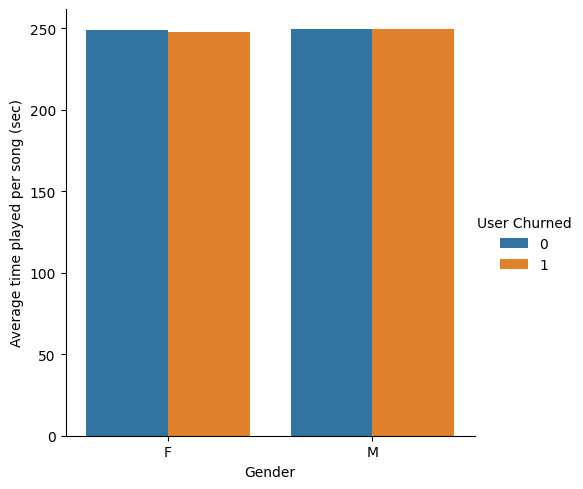

In [39]:
sns.catplot(
    data=df_churn_gender, kind="bar",
    x="gender", y="avg_length", hue="userChurned"
)\
.set_axis_labels("Gender", "Average time played per song (sec)")\
.legend.set_title("User Churned")

plt.savefig("plots/barplot_time_played_by_gender.png")

In [40]:
df_churn_device = df.groupBy(["deviceGroup", "userChurned"]).agg(
                                                F.count_distinct("userId").alias("user_count"),
                                                F.mean("length").alias("avg_length"), 
                                                (F.count("length").alias("played_songs") / F.count_distinct("userId")).alias("avg_songs_played")
                                                ).sort("deviceGroup", "userChurned").toPandas()

df_churn_device

,deviceGroup,userChurned,user_count,avg_length,avg_songs_played
0,Apple,0,79,249.379015,1113.367089
1,Apple,1,23,247.727890,638.695652
2,Linux,0,7,250.741211,849.000000
3,Linux,1,5,247.345489,271.400000
4,Windows,0,87,248.963293,1124.310345
5,Windows,1,24,249.371968,847.791667


The churn rate is slightly higher for users on Linux than on Windows or Apple devices.

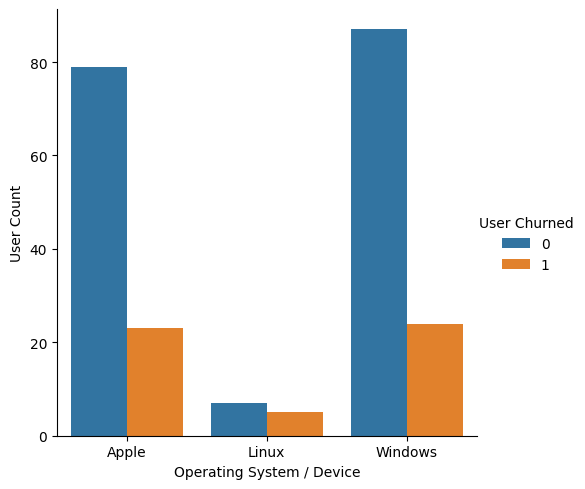

In [41]:
sns.catplot(
    data=df_churn_device, kind="bar",
    x="deviceGroup", y="user_count", hue="userChurned"
)\
.set_axis_labels("Operating System / Device", "User Count")\
.legend.set_title("User Churned")

plt.savefig("plots/barplot_churn_by_device.png")

The scatterplot shows that while there seems to be a correlation between the time a user has been registered and the number of songs that were played, there are also many users in the dataset that do not use the service extensively.

When we separate the scatterplot by churned / not churned, we see that most users churn within the first 100 days of using the service.

In [42]:
df_churn_scatter_user = df.groupBy(["userId", "userChurned"]).agg(
                                                F.count_distinct("userId").alias("user_count"),
                                                F.mean("length").alias("avg_length"), 
                                                F.count("length").alias("played_songs"),
                                                F.max("days_since_registration").alias("days_since_registration")
                                                ).sort("userId", "userChurned").toPandas()

df_churn_scatter_user.head(3)

,userId,userChurned,user_count,avg_length,played_songs,days_since_registration
0,10,0,1,247.944090,673,52
1,100,0,1,250.886598,2682,65
2,100001,1,1,263.712347,133,45


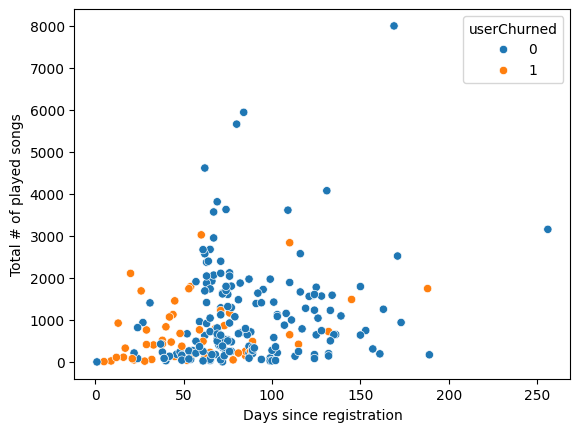

In [43]:
sns.scatterplot(data=df_churn_scatter_user, x="days_since_registration", y="played_songs", hue="userChurned").set(xlabel="Days since registration", ylabel="Total # of played songs")

plt.savefig("plots/scatter_played_songs_churn.png")

Which pages are visited the most? (e.g. Error, Thumbs Down, Help)

In [44]:
# Which pages do users interact with the most?
df.groupBy("page").count().sort("count", ascending=False).toPandas()

df_churn_page = df.groupBy("page", "userChurned").count().sort(["count", "page", "userChurned"], ascending=False)

window_page = Window.partitionBy(["page"])
df_churn_page = df_churn_page.withColumn("visits_page", F.sum(col("count")).over(window_page)).sort("userChurned").sort(["visits_page", "page"], ascending=False).toPandas()
df_churn_page.head()


,page,userChurned,count,visits_page
0,NextSong,0,191714,228108
1,NextSong,1,36394,228108
2,Thumbs Up,0,10692,12551
3,Thumbs Up,1,1859,12551
4,Home,0,8410,10082


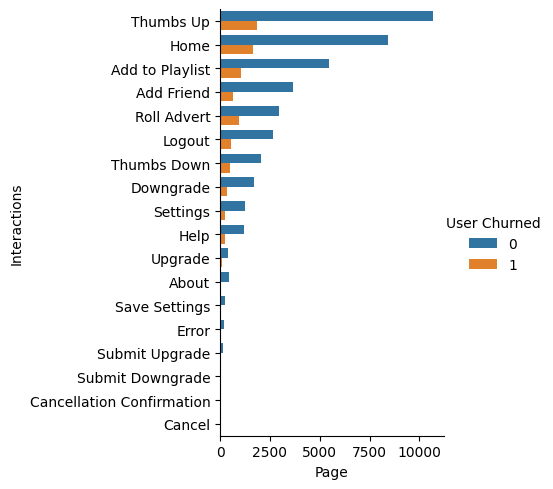

In [45]:
# Removed most frequent page "Next song" to see more details
sns.catplot(
    data=df_churn_page[2:], kind="bar",
    x="count", y="page", hue="userChurned", orient="y"
)\
.set_axis_labels("Page", "Interactions")\
.legend.set_title("User Churned")

plt.savefig("plots/barplot_churn_by_page.png")

# Some interactions seem to differ in frequency when separated by churned status. For example, churned users seem to have added fewer friends.

##### Usage statistics by churned / active and week

In [46]:
df.groupBy(["userChurned", "weekNum"]).agg(
                                                F.count_distinct("userId").alias("user_count"),
                                                F.max("userChurned").alias("userChurned"),
                                                F.mean("length").alias("avg_length"), 
                                                F.sum("length").alias("sum_length"),
                                                F.count("length").alias("played_songs"),
                                                (F.count("length").alias("played_songs") / F.count_distinct("userId")).alias("avg_songs_played")
                                                ).sort(["weekNum", "userChurned"]).show()

+-----------+-------+----------+-----------+------------------+------------------+------------+------------------+
|userChurned|weekNum|user_count|userChurned|        avg_length|        sum_length|played_songs|  avg_songs_played|
+-----------+-------+----------+-----------+------------------+------------------+------------+------------------+
|          0|     40|       116|          0|249.07581465804785|     3853202.85276|       15470|133.36206896551724|
|          1|     40|        46|          1|251.29148589659124|     1754517.15453|        6982| 151.7826086956522|
|          0|     41|       117|          0| 249.0836966144075|     4353235.76573|       17477| 149.3760683760684|
|          1|     41|        41|          1|246.75710027618663|2412297.4123000004|        9776| 238.4390243902439|
|          0|     42|       122|          0|249.09202399431004| 5515893.779330001|       22144|181.50819672131146|
|          1|     42|        34|          1|248.63771257003478|1783975.587689999

## Aggregations on user level

In [47]:
df.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+---------+-----------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|churnFlag|userChurned|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+

In [48]:
df_agg_user = df.groupBy(["userId"]).agg(
                                            F.max("userChurned").alias("userChurned"),
                                            F.max("gender").alias("gender"),
                                            F.max("level").alias("level"),
                                            F.mean("length").alias("avg_length"), 
                                            F.sum("length").alias("sum_length"),
                                            F.count("length").alias("played_songs"),
                                            F.max("state").alias("state"),
                                            F.max("deviceGroup").alias("deviceGroup"),
                                            F.max("days_since_registration").alias("days_since_registration")
                                        )


df_agg_user.show()

+------+-----------+------+-----+------------------+------------------+------------+--------+-----------+-----------------------+
|userId|userChurned|gender|level|        avg_length|        sum_length|played_songs|   state|deviceGroup|days_since_registration|
+------+-----------+------+-----+------------------+------------------+------------+--------+-----------+-----------------------+
|   100|          0|     M| paid|250.88659828113387|  672877.856590001|        2682|      TX|    Windows|                     65|
|100005|          1|     M| free|240.50079227272732| 37037.12201000001|         154|      LA|      Apple|                     85|
|100006|          1|     F| free|225.18811730769232|        5854.89105|          26|      MI|    Windows|                      9|
|100008|          0|     F| paid|247.92331090673568|191396.79601999995|         772|      CA|      Apple|                     68|
|100010|          0|     F| free|  243.421444909091| 66940.89735000003|         275|      

## Aggregations on user & week level

In [49]:
# df_agg = df.groupBy(["userId", "weekNum"]).agg({"length":"mean", "length":"sum", "length":"count"})

df_agg = df.groupBy(["userId", "weekNum"]).agg(
                                                F.max("userChurned").alias("userChurned"),
                                                F.mean("length").alias("avg_length"), 
                                                F.sum("length").alias("sum_length"),
                                                F.count("length").alias("played_songs")
                                                
                                                )


df_agg.where(df_agg.userId == 143).show()

window = Window.partitionBy(["userId"]).orderBy(["userId", "weekNum"])

# df_agg.withColumn("delta_playtime_wow", F.lag("sum_length", default=0).over(window)).show()

df_agg = df_agg.withColumn("delta_playtime_wow", (df_agg.sum_length / F.lag("sum_length", default=0).over(window)))

df_agg = df_agg.withColumn("delta_songs_played_wow", (df_agg.played_songs / F.lag("played_songs", default=0).over(window)))


df_agg.show()


+------+-------+-----------+------------------+------------------+------------+
|userId|weekNum|userChurned|        avg_length|        sum_length|played_songs|
+------+-------+-----------+------------------+------------------+------------+
|   143|     40|          1|247.14041907692314|16064.127240000003|          65|
|   143|     41|          1|237.30048294117643|4034.1082099999994|          17|
|   143|     42|          1|262.78725894736846| 4992.957920000001|          19|
+------+-------+-----------+------------------+------------------+------------+

+------+-------+-----------+------------------+------------------+------------+-------------------+----------------------+
|userId|weekNum|userChurned|        avg_length|        sum_length|played_songs| delta_playtime_wow|delta_songs_played_wow|
+------+-------+-----------+------------------+------------------+------------+-------------------+----------------------+
|   100|     40|          0| 244.2558602362204|62040.988499999985|    

#### Create tables with WoW changes in played songs / playtime per user

In [50]:
weeks_list = ["41", "42", "43", "44", "45", "46", "47", "48"]

##### WoW Playtime

In [51]:
wow_playtime_colnames = ["userId"] + [x + "_wow_pt_change" for x in weeks_list]

join_df_wow_playtime = df_agg.groupBy("userId").pivot("weekNum").max("delta_playtime_wow").fillna(0)

# Drop first and last week in dataset since no changes are present
join_df_wow_playtime = join_df_wow_playtime.drop("40", "49")
join_df_wow_playtime = join_df_wow_playtime.toDF(*wow_playtime_colnames)

join_df_wow_playtime.show(5)

+------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+
|userId|  41_wow_pt_change|   42_wow_pt_change|   43_wow_pt_change|  44_wow_pt_change|   45_wow_pt_change|   46_wow_pt_change|  47_wow_pt_change|   48_wow_pt_change|
+------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+
|   100|1.0391434266073956|  0.771417668170628|  2.042258737910301|1.2618010511778168|0.32610260221270276| 1.9445783374712677|0.9798185823454033| 0.8064724578674192|
|100005|               0.0|  0.912211317132697|                0.0|               0.0|                0.0|                0.0|               0.0|                0.0|
|100006|               0.0|                0.0|                0.0|               0.0|                0.0|                0.0|               0.0|                0.0|
|100

##### WoW Played Songs

In [52]:
wow_played_songs_colnames = ["userId"] + [x + "_wow_songs_change" for x in weeks_list]

join_df_wow_played_songs = df_agg.groupBy("userId").pivot("weekNum").max("delta_songs_played_wow").fillna(0)

# Drop first and last week in dataset since no changes are present
join_df_wow_played_songs = join_df_wow_played_songs.drop("40", "49")
join_df_wow_played_songs = join_df_wow_played_songs.toDF(*wow_played_songs_colnames)

join_df_wow_played_songs.show(5)

+------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|userId|41_wow_songs_change|42_wow_songs_change|43_wow_songs_change|44_wow_songs_change|45_wow_songs_change|46_wow_songs_change|47_wow_songs_change|48_wow_songs_change|
+------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|   100| 1.0236220472440944| 0.7576923076923077|  2.065989847715736| 1.2481572481572483|  0.328740157480315| 1.8922155688622755| 1.0031645569620253|  0.807570977917981|
|100005|                0.0| 0.8333333333333334|                0.0|                0.0|                0.0|                0.0|                0.0|                0.0|
|100006|                0.0|                0.0|                0.0|                0.0|                0.0|                0.0|                0.0|       

### Join DFs on User Level

In [53]:
# DFs to join
df_agg_user.show(3)
join_df_pages_share.show(3)
join_df_wow_played_songs.show(3)

+------+-----------+------+-----+------------------+-----------------+------------+-----+-----------+-----------------------+
|userId|userChurned|gender|level|        avg_length|       sum_length|played_songs|state|deviceGroup|days_since_registration|
+------+-----------+------+-----+------------------+-----------------+------------+-----+-----------+-----------------------+
|   100|          0|     M| paid|250.88659828113387| 672877.856590001|        2682|   TX|    Windows|                     65|
|100005|          1|     M| free|240.50079227272732|37037.12201000001|         154|   LA|      Apple|                     85|
|100006|          1|     F| free|225.18811730769232|       5854.89105|          26|   MI|    Windows|                      9|
+------+-----------+------+-----+------------------+-----------------+------------+-----+-----------+-----------------------+
only showing top 3 rows

+------+--------------------+--------------------+--------------------+--------------------+-

In [54]:
# Avoid duplicate column names by using a list inside the join function
# https://stackoverflow.com/questions/46944493/removing-duplicate-columns-after-a-df-join-in-spark

df_joined = df_agg_user.join(join_df_pages_share, ["userId"], "left")
df_joined = df_joined.join(join_df_wow_played_songs, ["userId"],  "left")

df_joined.show()

+------+-----------+------+-----+------------------+------------------+------------+--------+-----------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+-------------------+
|userId|userChurned|gender|level|        avg_length|        sum_length|played_songs|   state|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|       Save Sett

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [55]:
df_joined.show(3)

+------+-----------+------+-----+------------------+-----------------+------------+--------+-----------+-----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+--------------------+----------------+--------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+
|userId|userChurned|gender|level|        avg_length|       sum_length|played_songs|   state|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|          Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|Save Settings|            Settings|Subm

##### Prepare lists for easier automation of pipeline

In [56]:
# cols_for_transformation = ["state", "gender", "deviceGroup", "level"]
cols_for_transformation = ["gender", "deviceGroup", "level"]

indexed_cols = [x + "_index" for x in cols_for_transformation]
vectorized_cols = [x + "_vec" for x in cols_for_transformation]

vectorized_cols

['gender_vec', 'deviceGroup_vec', 'level_vec']

##### Index categorical variables

In [57]:
str_indexer = StringIndexer(inputCols=cols_for_transformation, outputCols=indexed_cols)
model = str_indexer.fit(df_joined)
df_transformed = model.transform(df_joined)

df_transformed = df_transformed.drop("gender").drop("state")

df_transformed.show(3)

+------+-----------+-----+------------------+-----------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+--------------------+----------------+--------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------+-----------------+-----------+
|userId|userChurned|level|        avg_length|       sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|          Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|Save Settings|            Se

##### Use One Hot Encoder for Indexed Variables

In [58]:
ohe = OneHotEncoder(inputCols=indexed_cols, outputCols=vectorized_cols)
model_ohe = ohe.fit(df_transformed)
df_transformed = model_ohe.transform(df_transformed)

df_transformed.show(3)

+------+-----------+-----+------------------+-----------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+--------------------+----------------+--------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------+-----------------+-----------+-------------+---------------+-------------+
|userId|userChurned|level|        avg_length|       sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|          Downgrade|               Error|                Help|                Home|              Logout|          NextSong|     

In [59]:
cols_for_vecAssembler = set(df_transformed.columns) - set(cols_for_transformation)
cols_for_vecAssembler.remove("userId")
cols_for_vecAssembler.remove("userChurned")

cols_for_vecAssembler = list(cols_for_vecAssembler)

In [60]:
vec_assembler = VectorAssembler(inputCols=cols_for_vecAssembler, outputCol="features")
df_transformed = vec_assembler.transform(df_transformed)
# df_transformed.groupby(["page", "page_numeric"]).count().sort("page_numeric").toPandas()

df_transformed.show(5)

+------+-----------+-----+------------------+------------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------+-----------------+-----------+-------------+---------------+-------------+--------------------+
|userId|userChurned|level|        avg_length|        sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|  

# Modeling

#### Handling of imbalanced data

Since we have an imbalanced data set (23% of users churned), adding a weight column for modeling is appropriate.

https://stackoverflow.com/questions/69464059/how-to-assign-class-weights-for-a-logistic-regression-model-in-apache-sparks-ml

In [61]:
df.groupBy(["userChurned"]).agg(F.count_distinct("userId").alias("user_count")).show()

print(f"Share of churned users: {52/(173+52)}")

df_transformed = df_transformed.withColumn("class_weight", F.when(df_transformed.userChurned == 1, 0.77).otherwise(0.23))
df_transformed.show(3)

+-----------+----------+
|userChurned|user_count|
+-----------+----------+
|          1|        52|
|          0|       173|
+-----------+----------+

Share of churned users: 0.2311111111111111
+------+-----------+-----+------------------+-----------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+--------------------+----------------+--------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------+-----------------+-----------+-------------+---------------+-------------+--------------------+------------+
|userId|userChurned|level|        avg_length|       sum_length|played_songs

Metrics used for evaluation:

Area Under the Receiver Operating Characteristic (AUROC) and area under the precision-recall curve (AUPR).

Interpretation of ROC / AUC: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

In [62]:
# Evaluation function

def print_eval_results(evaluator, predictions):
    print("Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
    print("Area Under PR-Curve: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})))


evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="userChurned", weightCol="class_weight")

### Logistic Regression

In [63]:
lr = LogisticRegression(featuresCol="features", labelCol="userChurned", weightCol="class_weight")

In [64]:
# https://www.geeksforgeeks.org/logistic-regression-using-pyspark-python/

# Split dataset into training and test
df_train, df_test = df_transformed.randomSplit([0.8, 0.2], seed=2)

model = lr.fit(df_train)

predictions_LR = model.transform(df_test)

df_train.show(3)

+------+-----------+-----+------------------+-----------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+--------------------+----------------+--------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------+-----------------+-----------+-------------+---------------+-------------+--------------------+------------+
|userId|userChurned|level|        avg_length|       sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|          Downgrade|               Error|                Help|                Home|           

In [65]:
predictions_LR.show(3)

+------+-----------+-----+------------------+------------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------+-----------------+-----------+-------------+---------------+-------------+--------------------+------------+--------------------+--------------------+----------+
|userId|userChurned|level|        avg_length|        sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|           Downgrade|  

In [66]:
print_eval_results(evaluator, predictions_LR)

Area Under ROC: 0.5753968253968255
Area Under PR-Curve: 0.470573020389186


In [67]:
model.summary.areaUnderROC

0.9008921330089212

#### Cross Validation / Grid Search
Since the AUC is much higher for the training data than for the test data, we likely have an overfitting problem. A simpler model may perform better with new data.

https://runawayhorse001.github.io/LearningApacheSpark/reg.html

In [68]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1, 0.2, 0.5]) \
    .addGrid(lr.maxIter, [50, 100, 200]) \
    .addGrid(lr.threshold, [0.4, 0.5, 0.6, 0.7, 0.8])\
    .build()


crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="userChurned", weightCol="class_weight"),
                          numFolds=3)

In [69]:
CV_model_LR = crossval.fit(df_train)

In [70]:
CV_model_LR.avgMetrics

[0.5538148711021051,
 0.5684613357485698,
 0.5652837263209604,
 0.56494702598426,
 0.5380217448036597,
 0.5527837263209603,
 0.5675985411357751,
 0.5822450057822398,
 0.5857803593175933,
 0.5524680697553038,
 0.5667464922784072,
 0.5815613070932221,
 0.5962077717396866,
 0.5960394215713364,
 0.5768475023794172,
 0.6027145185389866,
 0.5597362940448046,
 0.5855789403661744,
 0.5755732988445754,
 0.5551948051948051,
 0.6027145185389866,
 0.5597362940448046,
 0.5855789403661744,
 0.5755732988445754,
 0.5551948051948051,
 0.6027145185389866,
 0.5597362940448046,
 0.5855789403661744,
 0.5755732988445754,
 0.5551948051948051,
 0.6250488036392292,
 0.5523288866373973,
 0.5926711389477347,
 0.5406951992058375,
 0.5238095238095238,
 0.6250488036392292,
 0.5523288866373973,
 0.5926711389477347,
 0.5406951992058375,
 0.5238095238095238,
 0.6250488036392292,
 0.5523288866373973,
 0.5926711389477347,
 0.5406951992058375,
 0.5238095238095238,
 0.605624955226019,
 0.5999341822480121,
 0.5501842129501

In [71]:
cv_prediction_LR = CV_model_LR.transform(df_test)

print_eval_results(evaluator, cv_prediction_LR)

Area Under ROC: 0.5654761904761905
Area Under PR-Curve: 0.43651205674237037


In [72]:
# Get parameters of best model
# https://stackoverflow.com/questions/36697304/how-to-extract-model-hyper-parameters-from-spark-ml-in-pyspark

CV_model_LR.getEstimatorParamMaps()[ np.argmax(CV_model_LR.avgMetrics) ]

{Param(parent='LogisticRegression_a22778a2a6d5', name='regParam', doc='regularization parameter (>= 0).'): 0.2,
 Param(parent='LogisticRegression_a22778a2a6d5', name='maxIter', doc='max number of iterations (>= 0).'): 50,
 Param(parent='LogisticRegression_a22778a2a6d5', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.4}

### Random Forest

In [73]:
from pyspark.ml.classification import RandomForestClassifier


# Split dataset into training and test
df_train, df_test = df_transformed.randomSplit([0.8, 0.2], seed=2)

rf = RandomForestClassifier(featuresCol="features", labelCol="userChurned", weightCol="class_weight")

model_rf = rf.fit(df_train)

predictions_rf = model_rf.transform(df_test)

df_train.show(3)

+------+-----------+-----+------------------+-----------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+--------------------+----------------+--------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------+-----------------+-----------+-------------+---------------+-------------+--------------------+------------+
|userId|userChurned|level|        avg_length|       sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|          Downgrade|               Error|                Help|                Home|           

In [74]:
# See rows with incorrect predictions
predictions_rf.filter(predictions_rf.userChurned != predictions_rf.prediction).show()

+------+-----------+-----+------------------+------------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------+-----------------+-----------+-------------+---------------+-------------+--------------------+------------+--------------------+--------------------+----------+
|userId|userChurned|level|        avg_length|        sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|           Downgrade

In [75]:
print_eval_results(evaluator, predictions_rf)

Area Under ROC: 0.8293650793650793
Area Under PR-Curve: 0.8219889778453673


#### Cross Validation / Grid Search

In [76]:
rf_cv = RandomForestClassifier(featuresCol="features", labelCol="userChurned", weightCol="class_weight")

In [77]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf_cv.maxDepth,[3, 5, 10, 15]) \
    .addGrid(rf_cv.numTrees, [10, 20, 30, 40, 50]) \
    .build()


crossval_rf = CrossValidator(estimator=rf_cv,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="userChurned", weightCol="class_weight"),
                          numFolds=3)

In [78]:
CV_model_RF = crossval_rf.fit(df_train)

In [79]:
CV_model_RF.avgMetrics

[0.6931211814190538,
 0.7876073296286062,
 0.752274390306305,
 0.7691845634664783,
 0.7750016630335779,
 0.682181490692129,
 0.6717648240254622,
 0.6721131016343782,
 0.7121160311319885,
 0.6634413409679367,
 0.6321518759018758,
 0.6028181383234573,
 0.6541739584292775,
 0.6846964452017644,
 0.6853483543643119,
 0.6321518759018758,
 0.6028181383234573,
 0.6541739584292775,
 0.6846964452017644,
 0.6853483543643119]

In [80]:
cv_prediction_RF = CV_model_RF.transform(df_test)
print_eval_results(evaluator, cv_prediction_RF)

Area Under ROC: 0.9583333333333333
Area Under PR-Curve: 0.8865131578947368


In [81]:
# Get parameters of best model
# https://stackoverflow.com/questions/36697304/how-to-extract-model-hyper-parameters-from-spark-ml-in-pyspark

bestModel = CV_model_LR.bestModel
bestModel._java_obj.getRegParam()

CV_model_RF.getEstimatorParamMaps()[ np.argmax(CV_model_RF.avgMetrics) ]

{Param(parent='RandomForestClassifier_4cc013c4233b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 3,
 Param(parent='RandomForestClassifier_4cc013c4233b', name='numTrees', doc='Number of trees to train (>= 1).'): 20}

## Modeling Results Summary

During the model tuning, the random forest classifier consistently outperformed the logistic regression for both the AUROC and AUPR metrics. The final random forest classifier after cross-validation achieved and AUROC of 0.93 and the area under the PR curve is 0.82. However, one important thing to note is that  depending on the data selected for training, testing and validation with the function df,randomSplit(), the results sometimes differed significantly (from 0.73 – 0.93 for the AUROC). With a larger dataset, this value would likely be more stable. Nonetheless, the achieved values show that the classification is better than the baseline.